In [1]:
# 1) get the model from trained ATTITUDE_STARLINK

In [34]:
# just using the bounding box
#### get png and json filepaths

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['offset'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (XVALS) from the data
from skimage.color import rgb2gray
def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    try:
        ymin, ymax = np.min(y), np.max(y)
        xmin, xmax = np.min(x), np.max(x)
    except:
        ymin, ymax = 0, 0
        xmin, xmax = 0, 0
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = horiz_sums[horiz_sums>0.01]
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = vert_sums[vert_sums>0.01]
    vert_sums = [i for i in vert_sums]

    # # turn the horizontal and vertical sums into a spline, and sample 20 points
    # from scipy.interpolate import UnivariateSpline
    # horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
    # vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
    # horiz_spline.set_smoothing_factor(0.5)
    # vert_spline.set_smoothing_factor(0.5)

    # values_to_query = np.linspace(0, len(horiz_sums), 50)
    # horiz_spline_vals = horiz_spline(values_to_query)

    # values_to_query = np.linspace(0, len(vert_sums), 50)
    # vert_spline_vals  = vert_spline(values_to_query)

    return [height, width, ymin, ymax, xmin, xmax] 
            # \ + list(horiz_spline_vals) + list(vert_spline_vals)


import tqdm
dimensions = []
for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions


loading x vals: 100%|██████████| 10000/10000 [01:29<00:00, 111.22it/s]


In [35]:

# CHOOSE TRAINING AND TESTING INDICES

import random
random.seed(42)
data_percent = 0.7
n_pts_to_train = int(data_percent*len(xvals))

indices = list(range(len(xvals)))
random.shuffle(indices)
train_indices = indices[:n_pts_to_train]
test_indices = indices[n_pts_to_train:]
print(len(train_indices), len(test_indices))


7000 3000


geodesic distance, radians on test Extra trees 0.06509286393640892
geodesic distance, radians on test K-nn 0.067260094
geodesic distance, radians on test Ridge 0.06204737735098814
geodesic distance, radians on test Linear Regression 0.062047396
geodesic distance, radians on test Lasso Linear_0.5 0.06285031


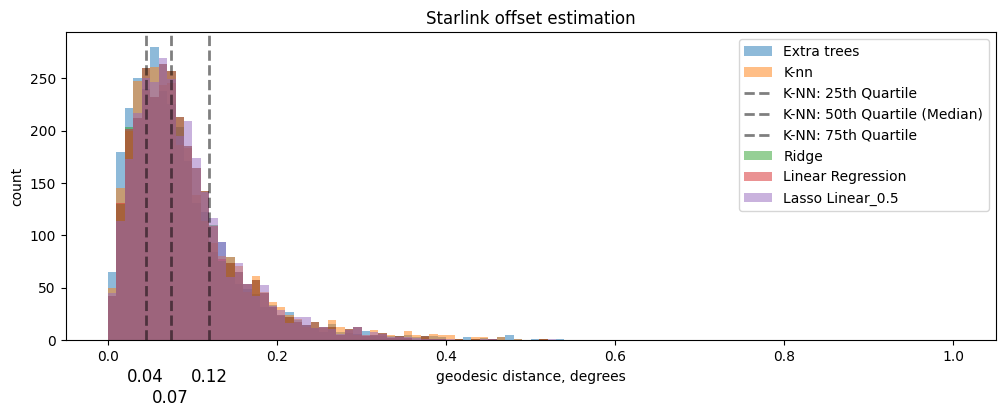

In [36]:

# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    # "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    # "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}


# import numpy as np

# def normalize_quaternion(q):
#     norm = np.linalg.norm(q, axis=-1)
#     return q / norm[...,np.newaxis]

# def geodesic_rot_distance(target, pred):
# #     # return np.pi - np.arccos(2*np.square(np.sum(pred*target, axis=-1))-1)
# #     # target_c = target.copy()
# #     # target_c = normalize_quaternion(target_c)
# #     # pred_c = pred.copy()
# #     # pred_c = normalize_quaternion(pred_c)
#     pred = pred.copy()
#     pred = normalize_quaternion(pred)
#     target = target.copy()
#     target = normalize_quaternion(target)
#     return 1 - np.abs(np.sum(pred * target, axis=-1))
    # return np.pi - 2 * np.arccos(abs(np.sum(pred * target, axis=-1)))
# from pyquaternion import Quaternion
# import pyquaternion

# def cos( A, B ):
#     """ comment cos between vectors or matrices """
#     Aflat = A.reshape(-1)  # views
#     Bflat = B.reshape(-1)
#     return (np.dot( Aflat, Bflat )
#         / max( np.linalg.norm(Aflat) * np.linalg.norm(Bflat), 1e-10 ))

def geodesic_rot_distance(target, pred):
    return np.linalg.norm(target - pred, axis=-1, ord=1)

# def geodesic_rot_distance(target, pred):
#     # convert quaternions to rotation matrices
#     target = target.copy().tolist()
#     pred = pred.copy().tolist()

#     for i in range(len(target)):
#         target[i] = pyquaternion.Quaternion(target[i]).rotation_matrix
#         pred[i]   = pyquaternion.Quaternion(pred[i]).rotation_matrix

#     # calculate the distance according to rotation matrix
#     distances = []
#     for i in range(len(target)):
#         distances.append(cos(target[i], pred[i]))

#     return np.array(distances)



# def geodesic_rot_distance(target, pred):
#     distances = []
#     for i in range(len(target)):
#         distances.append(Quaternion.distance(Quaternion(target[i]), Quaternion(pred[i])))
#     return np.array(distances)



########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 1
bin_width = 0.01  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)

y_test_predict = dict()
plt.figure(figsize=(12, 4))
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'geodesic distance, radians on test {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    data = np.abs(geodesic_rot_distance(y_vals[test_indices], y_test_predict[name]))
    plt.hist(data, bins=num_bins, range=(min_bin, max_bin), alpha=0.5, label=name)
    
    if name == 'K-nn':
        # Calculate QUARTILES values
        q25 = np.percentile(data, 25)
        q50 = np.percentile(data, 50)
        q75 = np.percentile(data, 75)

        # Add vertical lines for quartiles
        plt.axvline(q25, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='K-NN: 25th Quartile')
        plt.axvline(q50, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='K-NN: 50th Quartile (Median)')
        plt.axvline(q75, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='K-NN: 75th Quartile')
        
        plt.text(q25, -40, f'{q25:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q50, -60, f'{q50:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q75, -40, f'{q75:.2f}', color='black', fontsize=12, ha='center')

    plt.title('Starlink offset estimation')
    plt.xlabel('geodesic distance, degrees')
    plt.ylabel('count')
    plt.legend()
    # plt.show()


In [37]:
# using this MODEL (the best one); predict attitudes on the sequential data

In [94]:
def load_data(path:str="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1/data", spline:bool = False):
    # LOAD THE SEQUENTIAL DATA

    # just using the bounding box
    #### get png and json filepaths

    import glob
    import os
    import re
    from PIL import Image

    png_files = glob.glob(os.path.join(path, '*.png'))
    json_files = glob.glob(os.path.join(path, '*.json'))

    def extract_png_number(filename):
        match = re.search(r'(\d+).png$', filename)
        if match:   return int(match.group(1))
        else:       return -1
        
    def extract_json_number(filename):
        match = re.search(r'(\d+).json$', filename)
        if match:   return int(match.group(1))
        else:       return -1

    png_files.sort(key=extract_png_number)
    json_files.sort(key=extract_json_number)

    ## get the translations (YVALS) from the json files

    import os
    import json
    import numpy as np

    translations = []
    for json_f in json_files:
        with open(json_f) as f: translations.append(json.load(f)['offset'])

    translations = np.array(translations, dtype=np.float32)
    y_vals = translations


    # extract dimensions (XVALS) from the data
    from skimage.color import rgb2gray
    def model_dimensions(img_np:np.ndarray):

        # create object mask
        img_np_copy = img_np.copy()
        img_np_copy[np.where(img_np_copy<0.01)] = 0
        img_np_copy[np.where(img_np_copy>0.01)] = 1

        # determine object dimensions
        y,x,c = np.where(img_np_copy>0)
        try:
            ymin, ymax = np.min(y), np.max(y)
            xmin, xmax = np.min(x), np.max(x)
        except:
            ymin, ymax = 0, 0
            xmin, xmax = 0, 0
        height = ymax - ymin
        width = xmax - xmin

        # determine horizontal-wise pixel sums
        img_np_copy_bw = rgb2gray(img_np_copy.copy())
        horiz_sums = np.sum(img_np_copy_bw, axis=0)
        horiz_sums = horiz_sums/np.max(horiz_sums)
        horiz_sums = horiz_sums[horiz_sums>0.01]
        horiz_sums = [i for i in horiz_sums]

        # determine vertical-wise pixel sums
        vert_sums = np.sum(img_np_copy_bw, axis=1)
        vert_sums = vert_sums/np.max(vert_sums)
        vert_sums = vert_sums[vert_sums>0.01]
        vert_sums = [i for i in vert_sums]

        # turn the horizontal and vertical sums into a spline, and sample 20 points
        from scipy.interpolate import UnivariateSpline
        horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
        vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
        horiz_spline.set_smoothing_factor(0.5)
        vert_spline.set_smoothing_factor(0.5)

        values_to_query = np.linspace(0, len(horiz_sums), 50)
        horiz_spline_vals = horiz_spline(values_to_query)

        values_to_query = np.linspace(0, len(vert_sums), 50)
        vert_spline_vals  = vert_spline(values_to_query)

        if not spline: return [height, width, ymin, ymax, xmin, xmax] 
        else:          return [height, width, ymin, ymax, xmin, xmax] + list(horiz_spline_vals) + list(vert_spline_vals)


    import tqdm
    dimensions = []
    for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
        img = Image.open(png_f).convert('RGB')
        img_np = np.array(img)/255.0
        dimensions.append(model_dimensions(img_np))
    dimensions = np.array(dimensions, dtype=np.float32)
    xvals = dimensions

    return xvals, y_vals


In [97]:
xvals, yvals = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data", spline=True)
xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1/data", spline=True)

loading x vals: 100%|██████████| 101/101 [00:01<00:00, 91.20it/s]


lp score on test, Lasso Linear_0.5 [0.07618681 0.12715316 0.14615321 ... 0.06839192 0.20821021 0.07428101]


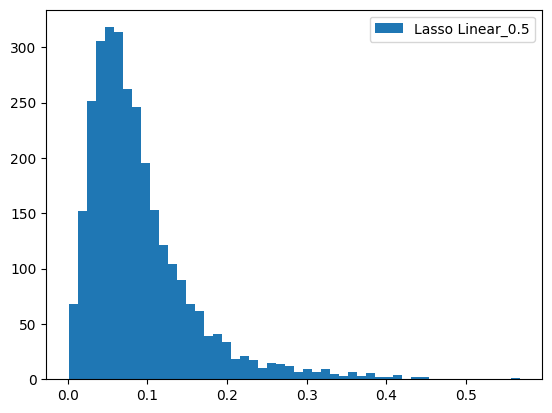

In [99]:
# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

def lp(true, pred, p):
    return np.linalg.norm(true - pred, axis=-1, ord=p)

p = 1
print(f'lp score on test, {name}', lp(y_vals[test_indices], y_pred, p))
plt.hist(lp(y_vals[test_indices], y_pred, p), bins=50, alpha=1, label=name)
plt.legend()
plt.show()

ESTIMATORS['MLP'] = clf

In [104]:

# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=100, max_features=32, random_state=0),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5)
    }

def geodesic_rot_distance(target, pred):
    return np.linalg.norm(target - pred, axis=-1, ord=1)

########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 1
bin_width = 0.01  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)

x_vals = xvals
y_vals = yvals

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])

ESTIMATORS['MLP'] = clf

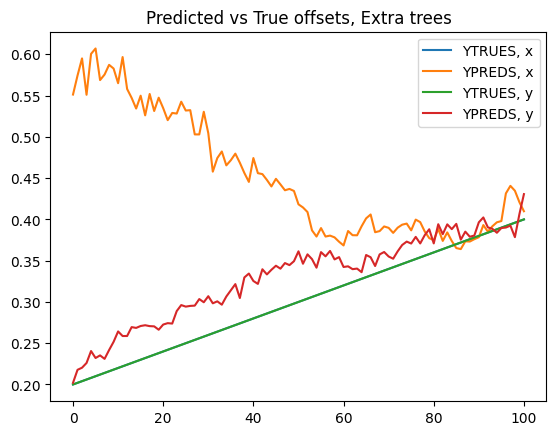

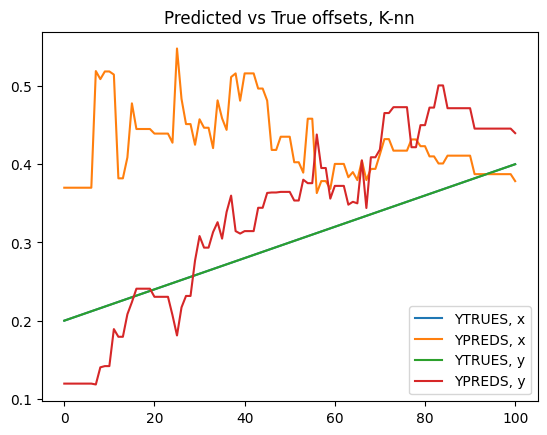

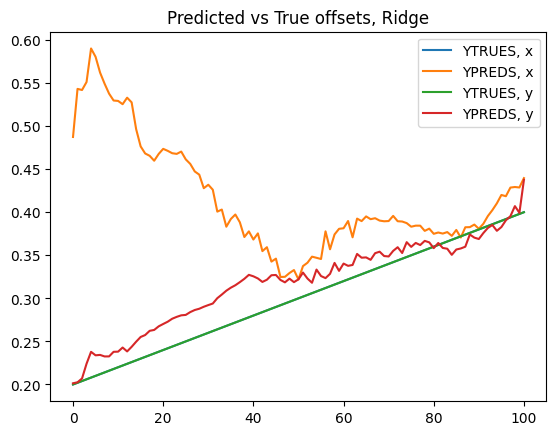

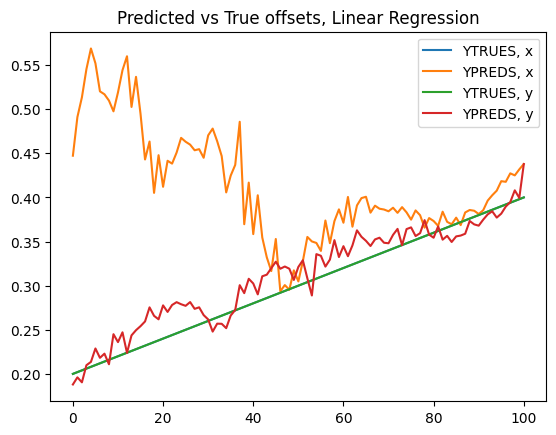

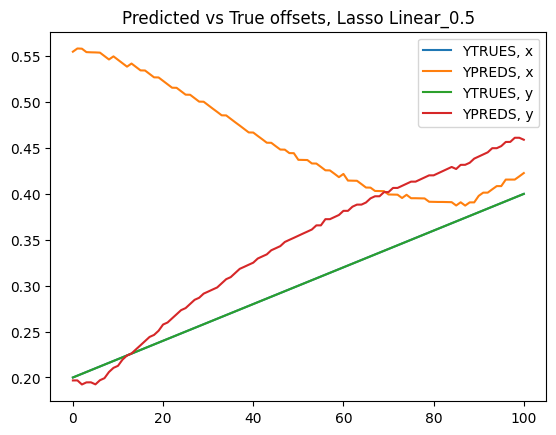

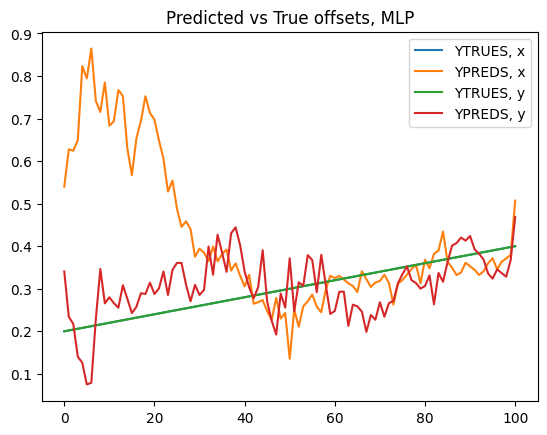

In [105]:

xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1/data", spline=True)

for key in ESTIMATORS.keys():
    MODEL = ESTIMATORS[key]

    if key == 'MLP':
        # scaler = StandardScaler()
        YPREDS = MODEL.predict(scaler.transform(xvals_seq))
        YTRUES = y_vals_seq
    else:
        YPREDS = MODEL.predict(xvals_seq)
        YTRUES = y_vals_seq
        min_bin = 0
        max_bin = 1

    # data = geodesic_rot_distance(YPREDS, YTRUES)
    # plt.hist(data, bins=1000, range=(min_bin, max_bin), alpha=0.5, label=name);
    # plt.plot()

    plt.title(f'Predicted vs True offsets, {key}')
    plt.plot(YTRUES[:,0], label='YTRUES, x')
    plt.plot(YPREDS[:,0], label='YPREDS, x')
    plt.plot(YTRUES[:,1], label='YTRUES, y')
    plt.plot(YPREDS[:,1], label='YPREDS, y')

    plt.legend()
    plt.show()


loading x vals: 100%|██████████| 101/101 [00:01<00:00, 76.30it/s]


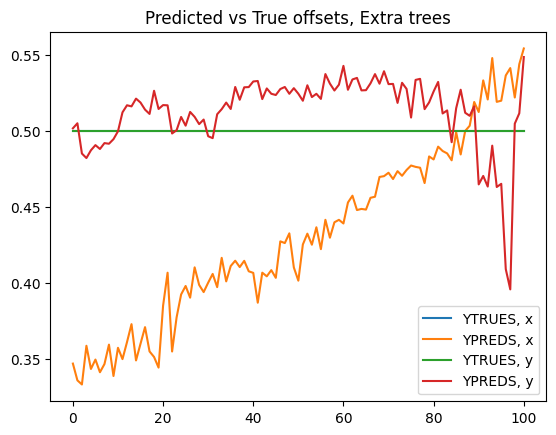

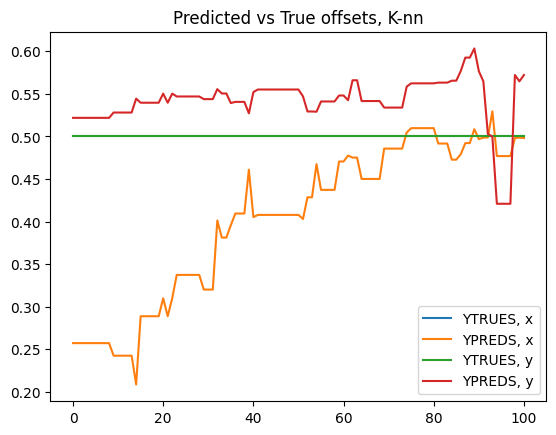

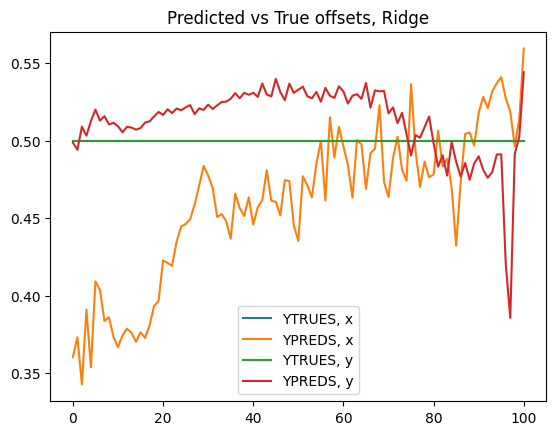

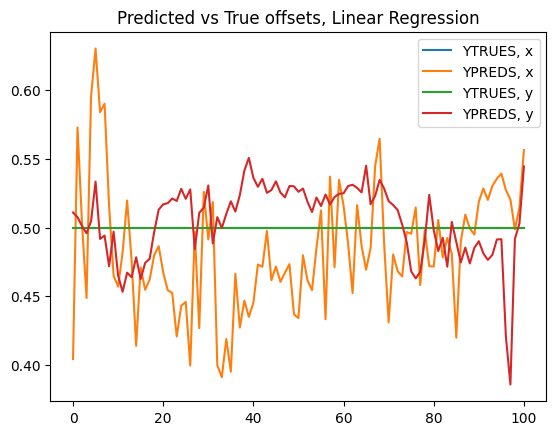

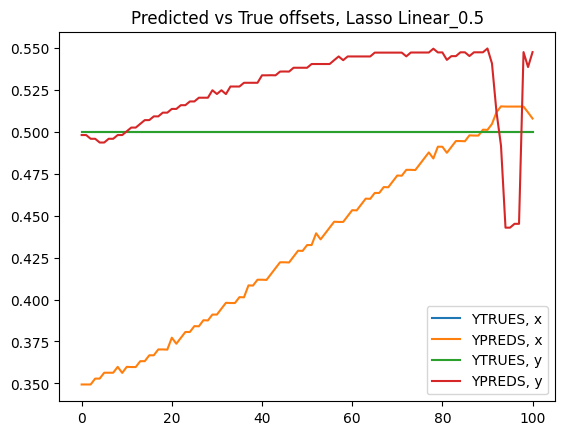

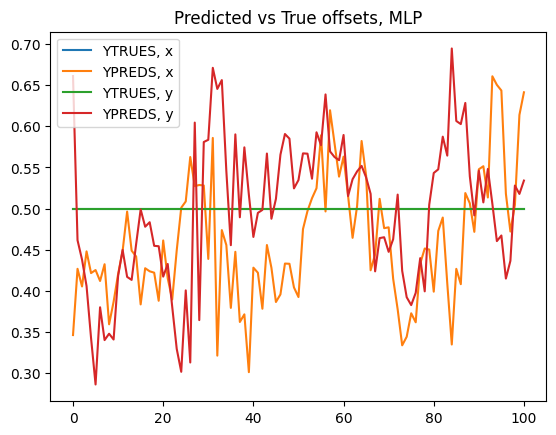

In [106]:

xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence2/data", spline=True)

for key in ESTIMATORS.keys():
    MODEL = ESTIMATORS[key]

    if key == 'MLP':
        # scaler = StandardScaler()
        YPREDS = MODEL.predict(scaler.transform(xvals_seq))
        YTRUES = y_vals_seq
    else:
        YPREDS = MODEL.predict(xvals_seq)
        YTRUES = y_vals_seq
        min_bin = 0
        max_bin = 1

    plt.title(f'Predicted vs True offsets, {key}')
    plt.plot(YTRUES[:,0], label='YTRUES, x')
    plt.plot(YPREDS[:,0], label='YPREDS, x')
    plt.plot(YTRUES[:,1], label='YTRUES, y')
    plt.plot(YPREDS[:,1], label='YPREDS, y')

    plt.legend()
    plt.show()


loading x vals: 100%|██████████| 101/101 [00:00<00:00, 107.23it/s]


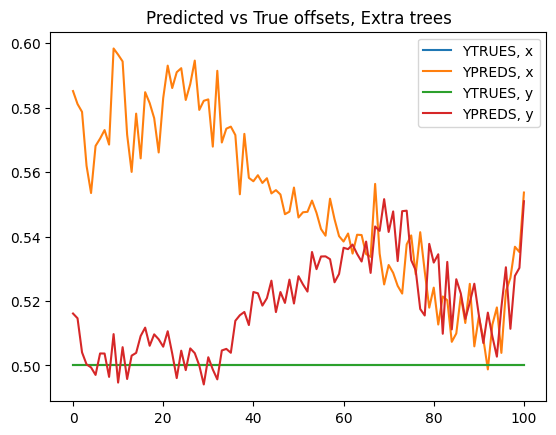

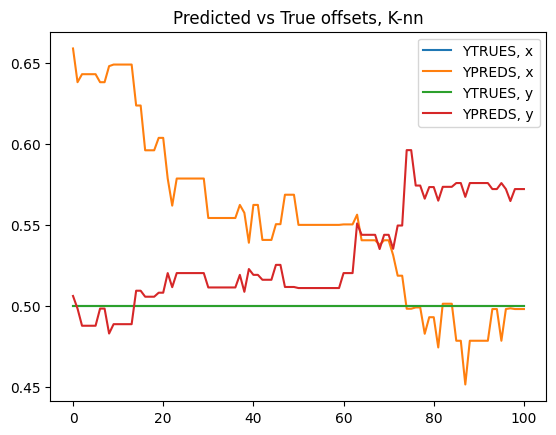

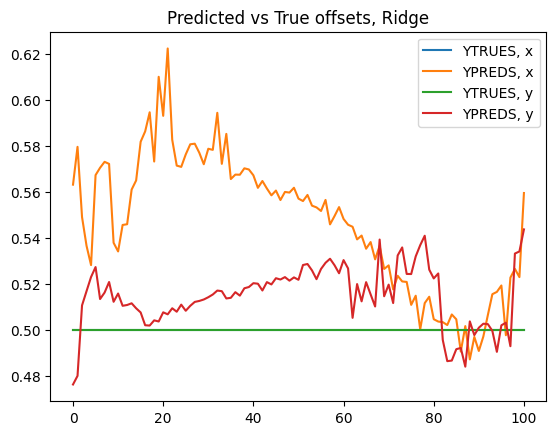

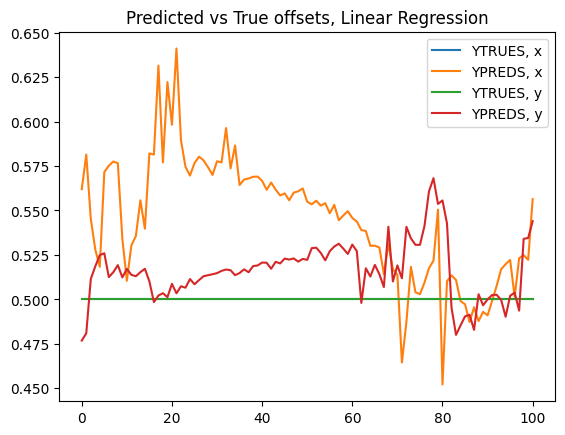

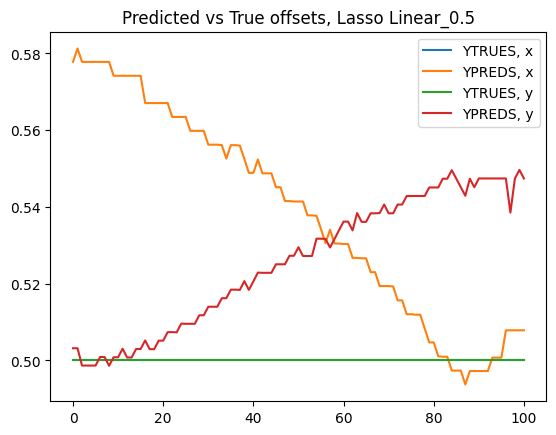

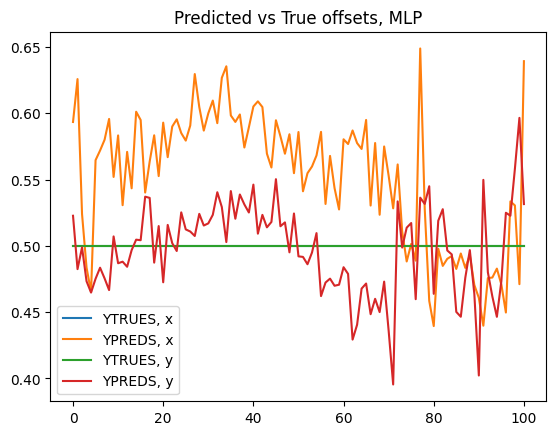

In [107]:

xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence3/data", spline=True)

for key in ESTIMATORS.keys():
    MODEL = ESTIMATORS[key]

    if key == 'MLP':
        # scaler = StandardScaler()
        YPREDS = MODEL.predict(scaler.transform(xvals_seq))
        YTRUES = y_vals_seq
    else:
        YPREDS = MODEL.predict(xvals_seq)
        YTRUES = y_vals_seq
        min_bin = 0
        max_bin = 1

    plt.title(f'Predicted vs True offsets, {key}')
    plt.plot(YTRUES[:,0], label='YTRUES, x')
    plt.plot(YPREDS[:,0], label='YPREDS, x')
    plt.plot(YTRUES[:,1], label='YTRUES, y')
    plt.plot(YPREDS[:,1], label='YPREDS, y')

    plt.legend()
    plt.show()


In [108]:
# now adding filtering

In [109]:
## EQUATIONS !!!

def xhat_next_pred(xhat, xdothat, dt):
    xhat_next = xhat + dt * xdothat
    return xhat_next

def xdothat_next_pred(xdothat):
    xdothat_next = xdothat
    return xdothat_next

def xhat_next_meas(xhat_next, alpha, z_n):
    return xhat_next + alpha * (z_n - xhat_next)

def xdothat_next_meas(xdothat_next, beta, z_n, dt, xhat_next):
    return xdothat_next + beta * (z_n - xhat_next)/dt


In [181]:

def find_next(xhat, xdothat, z_n, timestep, dt, alpha, beta):
    xhat_10 = xhat_next_pred(xhat, xdothat, dt)
    xdothat_10 = xdothat_next_pred(xdothat)
    xhat_11 = xhat_next_meas(xhat_10, alpha, z_n[timestep])
    xdothat_11 = xdothat_next_meas(xdothat_10, beta, z_n[timestep], dt, xhat_10)
    xhat_next = xhat_11
    xdothat_next = xdothat_11
    return xhat_next, xdothat_next


In [182]:
# PREDICTIONS


xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1/data", spline=True)
key = 'MLP'
MODEL = ESTIMATORS[key]
YPREDS = MODEL.predict(scaler.transform(xvals_seq)) # 'measurements'
YTRUES = y_vals_seq
z_n = YPREDS



loading x vals:   0%|          | 0/101 [00:00<?, ?it/s]

loading x vals: 100%|██████████| 101/101 [00:00<00:00, 108.47it/s]


loading x vals:   0%|          | 0/101 [00:00<?, ?it/s]

loading x vals: 100%|██████████| 101/101 [00:01<00:00, 94.32it/s]


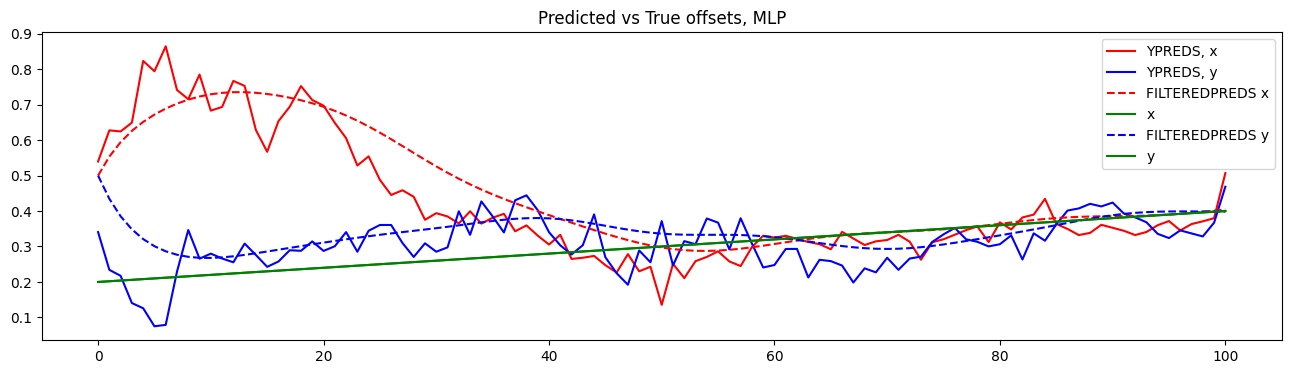

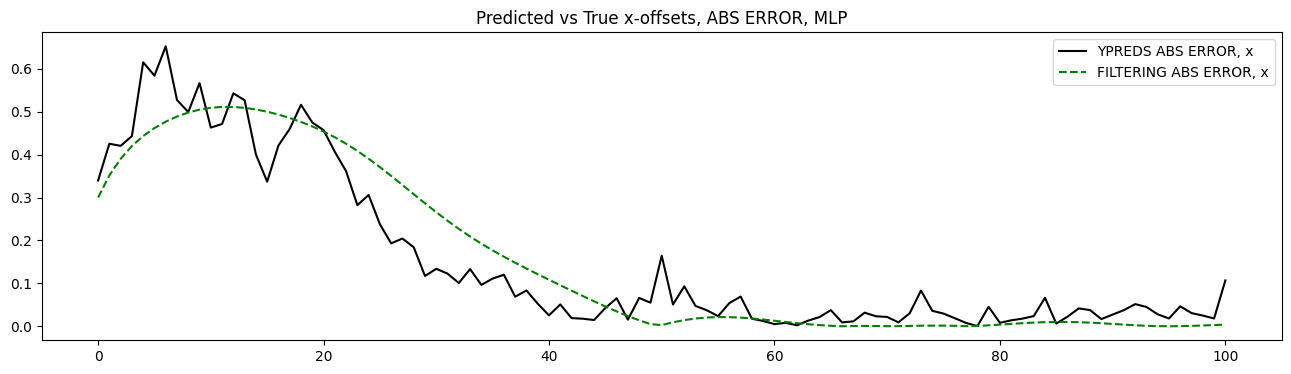

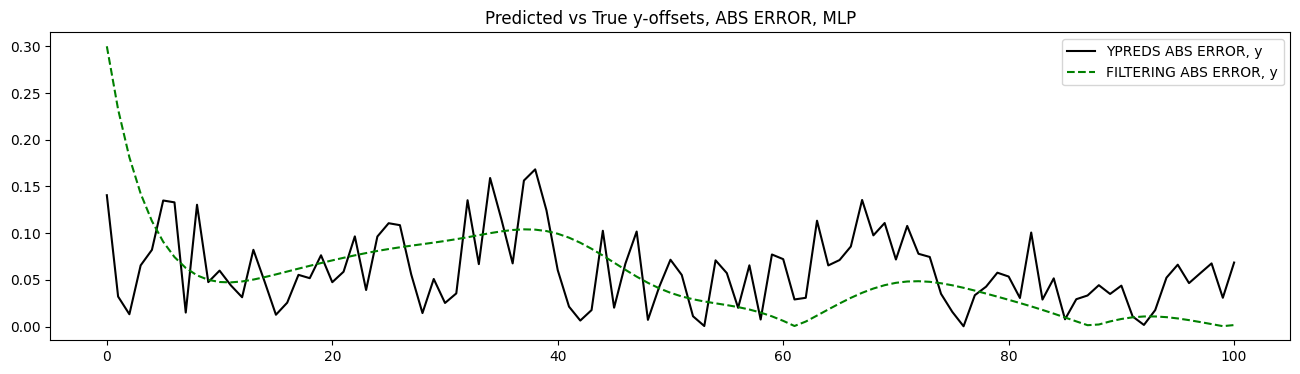

In [236]:
## EQUATIONS

def xhat_next_pred(xhat, xdothat, dt):
    xhat_next = xhat + dt * xdothat
    return xhat_next

def xdothat_next_pred(xdothat):
    xdothat_next = xdothat
    return xdothat_next

def xhat_next_meas(xhat_next, alpha, z_n):
    return xhat_next + alpha * (z_n - xhat_next)

def xdothat_next_meas(xdothat_next, beta, z_n, dt, xhat_next):
    return xdothat_next + beta * (z_n - xhat_next)/dt


# HYPERPARAMETERS

dt = 1
alpha = 0.25
beta = 0.0001

xhat_00 = np.array([0.5, 0.5])          # initial position guesses
xdothat_00 = np.array([0.01, 0.01])


# PREDICTIONS
xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1/data", spline=True)

key = 'MLP'
MODEL = ESTIMATORS[key]
YPREDS = MODEL.predict(scaler.transform(xvals_seq)) # 'measurements'
YTRUES = y_vals_seq
z_n = YPREDS


# smooth the predictions
from scipy.ndimage import gaussian_filter1d
z_n = np.array(list(zip(gaussian_filter1d(z_n[:,0], sigma=5), gaussian_filter1d(z_n[:,1], sigma=5))))

xhat_now = xhat_00
xdothat_now = xdothat_00

xhats = [xhat_now]
xs = []
xdothats = [xdothat_now]

for timestep in range(len(z_n)):
    xhat_now, xdothat_now = find_next(xhat_now, xdothat_now, z_n, timestep, dt, alpha, beta)
    xhats.append(xhat_now)
    xdothats.append(xdothat_now)
    xs.append(YTRUES[timestep])

xhats = xhats[:-1]
xdothats = xdothats[:-1]

plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True offsets, {key}')
plt.plot(np.array(YPREDS)[:,0], label='YPREDS, x', linestyle='solid', color='red')
plt.plot(np.array(YPREDS)[:,1], label='YPREDS, y', linestyle='solid', color='blue')
plt.plot(np.array(xhats)[:,0], label='FILTEREDPREDS x', linestyle='--', color='red', )
plt.plot(np.array(xs)[:,0], label='x', color='green', linestyle='solid')
plt.plot(np.array(xhats)[:,1], label='FILTEREDPREDS y', linestyle='--', color='blue')
plt.plot(np.array(xs)[:,1], label='y', color='green', linestyle='solid')
plt.legend();
plt.show()

# plot L2 distance between filtered and unfiltered predictions
plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True x-offsets, ABS ERROR, {key}')

def lp(true, pred, p):
    return np.linalg.norm(true - pred, axis=-1, ord=p)

plt.plot(np.abs(np.array(YPREDS)[:,0] - np.array(xs)[:,0]), label='YPREDS ABS ERROR, x', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,0] - np.array(xs)[:,0]), label='FILTERING ABS ERROR, x', linestyle='--', color='green')
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True y-offsets, ABS ERROR, {key}')
plt.plot(np.abs(np.array(YPREDS)[:,1] - np.array(xs)[:,1]), label='YPREDS ABS ERROR, y', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,1] - np.array(xs)[:,1]), label='FILTERING ABS ERROR, y', linestyle='--', color='green')
plt.legend()
plt.show()
